In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, LabelBinarizer
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.utils import Sequence
from keras.layers import Dense, LSTM, Dropout, Activation, Flatten, TimeDistributed
from bisect import bisect
from collections import Counter

Using TensorFlow backend.


# Read Data From CSV

In [6]:
col_names = ['Timestamp', 'MAC Address', 'RX Bytes', 'TX Bytes', 'RX Packets', 'TX Packets', 'Signal', 'RX Bitrate', 'TX Bitrate', 'Inactive Time', 'Tag']
types = ['float', 'str', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'str']
dtypes = dict(zip(col_names, types))
data = pd.read_csv('data.csv', names=col_names, dtype=dtypes, usecols=col_names[2:])
data['Class'] = data['Tag'].apply(lambda tag: tag.split('|')[0])
data['Mobility'] = data['Tag'].apply(lambda tag: tag.split('|')[-1])
del data['Tag']
#def class_tagger(cls):
#    return 'other' if cls in ['web_browsing', 'telegram_chat'] else cls
#data['Class'] = data['Class'].apply(class_tagger)
data.head()

,RX Bytes,TX Bytes,RX Packets,TX Packets,Signal,RX Bitrate,TX Bitrate,Inactive Time,Class,Mobility
0,4882586.0,334225074.0,38703.0,243072.0,-28.0,24.0,780.0,10.0,video_youtube,stationary
1,4927228.0,334932024.0,39007.0,243623.0,-27.0,24.0,650.0,100.0,video_youtube,stationary
2,4967254.0,336080850.0,39442.0,244443.0,-28.0,24.0,780.0,20.0,video_youtube,stationary
3,5056480.0,338643818.0,40411.0,246264.0,-29.0,24.0,650.0,160.0,video_youtube,stationary
4,5056480.0,338643818.0,40411.0,246264.0,-29.0,24.0,650.0,1180.0,video_youtube,stationary


# Preprocess Data

In [7]:
diff_columns = ['RX Bytes', 'TX Bytes', 'RX Packets', 'TX Packets']
for column in diff_columns:
    data[column] = data[column].diff()
#data['RX Density'] = data['RX Bytes'] / data['RX Packets'].apply(lambda x: max(x, 1))
#data['TX Density'] = data['TX Bytes'] / data['TX Packets'].apply(lambda x: max(x, 1))
#order = ['RX Bytes', 'TX Bytes', 'RX Density', 'TX Density', 'Signal', 'RX Bitrate', 'TX Bitrate', 'Class', 'Mobility']
#data = data[order]

new_class = (data['Class'] != data['Class'].shift()) | (data['Mobility'] != data['Mobility'].shift())
data = data[~new_class] # Remove first row of each measurement
encoders = dict(zip(data.columns.values, [MinMaxScaler() for _ in range(8)] + [LabelEncoder() for _ in range(2)]))
for column, encoder in encoders.items():
    if isinstance(encoder, MinMaxScaler):
        data.loc[:, column] = encoder.fit_transform(data[column].values.reshape(-1, 1))
    else:
        data.loc[:, column] = encoder.fit_transform(data[column])

measurement_id = ((data['Class'] != data['Class'].shift()) | (data['Mobility'] != data['Mobility'].shift())).cumsum()
dataset = [measurement.reset_index(drop=True) for _, measurement in data.groupby(measurement_id)]
#dataset[7], dataset[-1] = dataset[-1], dataset[7]
dataset[0].head()

,RX Bytes,TX Bytes,RX Packets,TX Packets,Signal,RX Bitrate,TX Bitrate,Inactive Time,Class,Mobility
0,0.103406,0.031487,0.063347,0.035330,0.983607,0.020344,0.748082,0.003338,4,1
1,0.092714,0.051169,0.090644,0.052578,0.967213,0.020344,0.899209,0.000668,4,1
2,0.206678,0.114154,0.201917,0.116761,0.950820,0.020344,0.748082,0.005340,4,1
3,0.000000,0.000000,0.000000,0.000000,0.950820,0.020344,0.748082,0.039386,4,1
4,0.000000,0.000004,0.000000,0.000064,0.950820,0.020344,0.748082,0.073765,4,1


# View Data

Text(0, 0.5, 'Normalized Bytes')

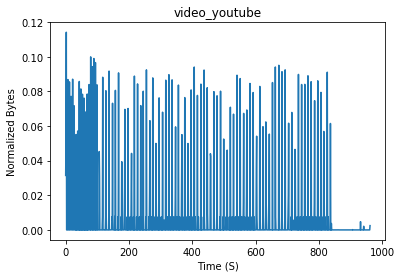

In [47]:
ida = 0
field = 'TX Bytes'
plt.plot(dataset[ida][field].values)
plt.title(encoders['Class'].classes_[dataset[ida]['Class']][0])
plt.xlabel('Time (S)')
plt.ylabel('Normalized Bytes')

Text(0, 0.5, 'Normalized Bytes')

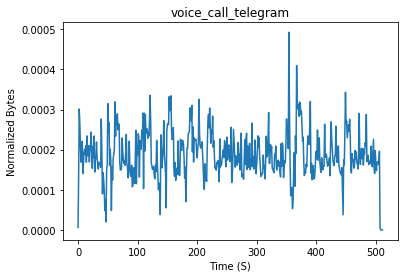

In [62]:
ida = 3
field = 'TX Bytes'
plt.plot(dataset[ida][field].values)
plt.title(encoders['Class'].classes_[dataset[ida]['Class']][0])
plt.xlabel('Time (S)')
plt.ylabel('Normalized Bytes')

# Create A Generator

In [9]:
class TrafficSequence(Sequence):
    def __init__(self, dataset, time_step, batch_size, skip_step, features, target, num_targets, shuffle=None):
        self.dataset, self.time_step, self.batch_size = dataset, time_step, batch_size
        self.skip_step, self.features, self.target, self.num_targets = skip_step, features, target, num_targets
        self.time_frames = [(len(data) - self.time_step + 1) for data in self.dataset]
        self.data_count = [(time_frames + self.skip_step - 1) // self.skip_step for time_frames in self.time_frames]
        self.data_cum = np.cumsum(self.data_count)
        if shuffle:
            new_dataset = []
            for data in dataset:
                data_c = data.copy()
                col = data_c[shuffle].values
                np.random.shuffle(col)
                data_c[shuffle] = col
                new_dataset.append(data_c)
            self.dataset = new_dataset

    def __len__(self):
        return int(np.ceil(self.data_cum[-1] / self.batch_size))

    def get_single_item(self, idx):
        dataset_idx = bisect(self.data_cum, idx)
        in_dataset_idx = idx
        if dataset_idx > 0:
            in_dataset_idx -= self.data_cum[dataset_idx - 1]
        x = self.dataset[dataset_idx].loc[in_dataset_idx * self.skip_step:in_dataset_idx * self.skip_step + self.time_step - 1, self.features]
        y = np.zeros(self.num_targets)
        y[self.dataset[dataset_idx].loc[0, self.target]] = 1
        return x.values, y
    
    def __getitem__(self, idx):
        indices = range(idx * self.batch_size, (idx + 1) * self.batch_size)
        indices = [i % self.data_cum[-1] for i in indices]
        batch_x = np.ndarray(shape=(self.batch_size, self.time_step, len(self.features)))
        batch_y = np.ndarray(shape=(self.batch_size, self.num_targets))
        for i, ind in enumerate(indices):
            x, y = self.get_single_item(ind)
            batch_x[i, :, :] = x
            batch_y[i, :] = y
        return batch_x, batch_y

# Train an LSTM Model

In [10]:
def train_model(dataset, features, target, hidden_size=64, time_step=30, skip_step=1, batch_size=20, epochs=50, dropout=0.2, save=True):
    class_count = len(encoders[target].classes_)
    train_generator = TrafficSequence(dataset, time_step, batch_size, skip_step, features, target, class_count)
    model = Sequential()
    model.add(LSTM(units=hidden_size, unroll=True, return_sequences=True, dropout=dropout, recurrent_dropout=dropout, input_shape=(time_step, len(features))))
    model.add(Dropout(dropout))
    #model.add(LSTM(units=hidden_size, return_sequences=True))
    #model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(class_count))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    callbacks = [ModelCheckpoint(filepath='checkpoint/model-%s-{epoch:04d}.hdf5' % target, verbose=1)] if save else []
    #model.summary()
    model.fit_generator(train_generator, epochs=epochs, callbacks=callbacks, use_multiprocessing=True, workers=8, shuffle=True)
    return model

# See the result

In [53]:
def evaluate_model(dataset, model, features, target, time_step=30):
    class_count = len(encoders[target].classes_)
    train_generator = TrafficSequence(dataset, time_step, 1, 1, features, target, class_count)
    idx = 0
    predict_map = np.zeros(shape=(len(encoders[target].classes_), len(encoders[target].classes_)))
    for d, count in zip(dataset, train_generator.time_frames):
        true_class = encoders[target].inverse_transform([d.loc[0, target]])[0]
        #print('Dataset', true_class)
        lst = []
        for _ in range(count):
            x, t = train_generator.get_single_item(idx)
            y = model.predict(np.array([x]))
            y_int = np.argmax(y)
            lst.append(y_int)
            idx += 1
        ctr = Counter(lst)
        total = 0
        for (item, cnt) in ctr.most_common():
            predicted_class = encoders[target].inverse_transform([item])[0]
            percent = cnt * 100 / len(lst)
            predict_map[d.loc[0, target]][item] += cnt
            #print('Predicted', predicted_class, '%.2f' % percent)
    for i in range(len(predict_map)):
        true_label = encoders[target].inverse_transform([i])[0]
        print('Accuracy(%s): %.2f' % (true_label, predict_map[i][i] * 100 / np.sum(predict_map[i])))
    total_cnt = np.sum(predict_map)
    correct_cnt = np.sum(predict_map * np.eye(len(predict_map)))
    print('Total Accuracy: %.2f' % (correct_cnt * 100 / total_cnt))
    label_map = {}
    for true in range(len(predict_map)):
        true_label = encoders[target].inverse_transform([true])[0]
        total = 0
        for pred in range(len(predict_map)):
            pred_label = encoders[target].inverse_transform([pred])[0]
            amount = predict_map[true][pred] / predict_map[true].sum()
            if pred_label not in label_map:
                bar = plt.barh(true_label, amount, left=total, label=pred_label)
                color = bar.get_children()[0].get_facecolor()
                label_map[pred_label] = color
            else:
                bar = plt.barh(true_label, amount, left=total, color=label_map[pred_label], label='_' + pred_label)
            total += amount
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Prediction Ratio')
    plt.ylabel('True Label')
    plt.title('Classification Evaluation')

# Divide Train Set and Test Set

In [12]:
train_class_data, test_class_data = dataset[7:], dataset[:7]

In [13]:
train_mobility_data, test_mobility_data = [], []
for data in dataset:
    length = len(data)
    train_mobility_data.append(data.loc[:length*2//3, :].reset_index(drop=True))
    test_mobility_data.append(data.loc[length*2//3:, :].reset_index(drop=True))

# Train Classification Model

In [22]:
#class_train_model = train_model(train_class_data, data.columns.values[:-2], 'Class', epochs=100)

In [14]:
class_train_model = load_model('checkpoint-final/model-Class-5000.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [45]:
mobility_train_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 30, 64)            18688     
_________________________________________________________________
dropout_21 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 1920)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 3842      
_________________________________________________________________
activation_21 (Activation)   (None, 2)                 0         
Total params: 22,530
Trainable params: 22,530
Non-trainable params: 0
_________________________________________________________________


Accuracy(download_large): 100.00
Accuracy(idle_phone): 99.40
Accuracy(telegram_chat): 100.00
Accuracy(video_call_duo): 100.00
Accuracy(video_youtube): 100.00
Accuracy(voice_call_duo): 100.00
Accuracy(voice_call_telegram): 100.00
Total Accuracy: 99.86


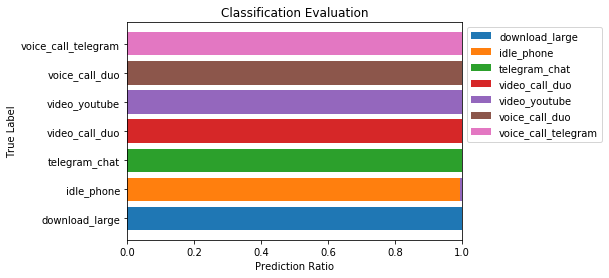

In [54]:
evaluate_model(train_class_data, class_train_model, data.columns.values[:-2], 'Class')

Accuracy(download_large): 97.84
Accuracy(idle_phone): 83.91
Accuracy(telegram_chat): 89.23
Accuracy(video_call_duo): 78.66
Accuracy(video_youtube): 92.93
Accuracy(voice_call_duo): 100.00
Accuracy(voice_call_telegram): 100.00
Total Accuracy: 91.93


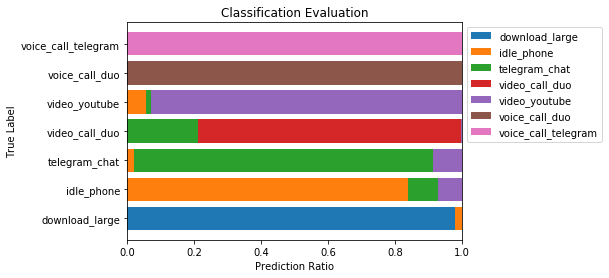

In [55]:
evaluate_model(test_class_data, class_train_model, data.columns.values[:-2], 'Class')

# Calculate Feature Importance

In [17]:
def evaluate_with_shuffle(model, dataset, features, target, shuffle=None, count=5):
    res = []
    for i in range(5):
        train_total_generator = TrafficSequence(dataset, 30, 1, 1, features, target, len(encoders[target].classes_), shuffle=shuffle)
        train_total_generator.batch_size = len(train_total_generator)
        X_Train, Y_Train = train_total_generator[0]
        [loss, _] = model.evaluate(X_Train, Y_Train)
        res.append(loss)
    return sum(res) / count

In [18]:
def get_feature_importance(model, dataset, features, target):
    normal_loss = evaluate_with_shuffle(model, dataset, features, target)
    losses = dict([(column, evaluate_with_shuffle(model, dataset, features, target, shuffle=column)) for column in features])
    importance = {}
    for (feature, loss) in losses.items():
        importance[feature] = loss - normal_loss
    plt.barh(list(importance.keys()), list(importance.values()))
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')

4843/4843 [==============================] - 0s 73us/step


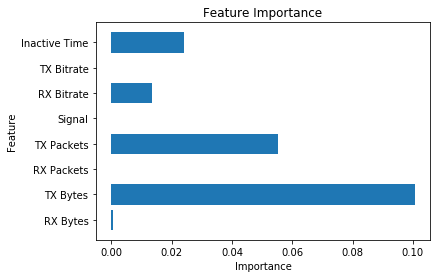

In [19]:
get_feature_importance(class_train_model, train_class_data, data.columns.values[:-2], 'Class')

# Train Mobility Model

In [ ]:
#mobility_train_model = train_model(train_mobility_data, data.columns.values[:-2], 'Mobility', epochs=5000, dropout=0.05)

In [20]:
mobility_train_model = load_model('checkpoint/model-Mobility-5000.hdf5')

Accuracy(mobile): 99.88
Accuracy(stationary): 100.00
Total Accuracy: 99.96


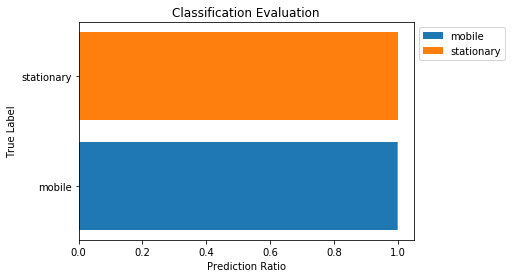

In [58]:
evaluate_model(train_mobility_data, mobility_train_model, data.columns.values[:-2], 'Mobility')

Accuracy(mobile): 98.91
Accuracy(stationary): 97.41
Total Accuracy: 97.87


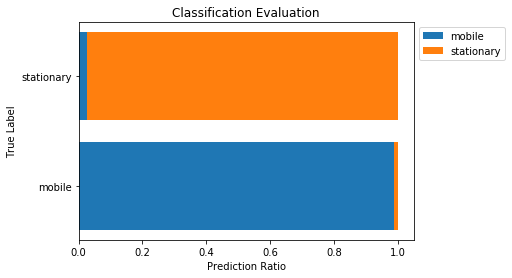

In [59]:
evaluate_model(test_mobility_data, mobility_train_model, data.columns.values[:-2], 'Mobility')

4843/4843 [==============================] - 1s 267us/step


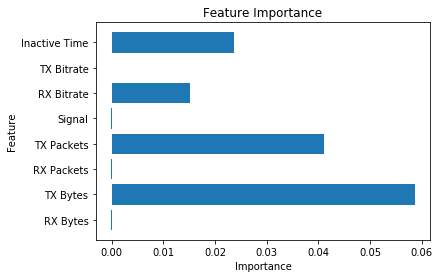

In [60]:
get_feature_importance(class_train_model, train_class_data, data.columns.values[:-2], 'Class')

5394/5394 [==============================] - 0s 68us/step


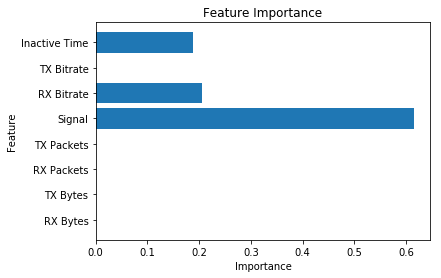

In [23]:
get_feature_importance(mobility_train_model, train_mobility_data, data.columns.values[:-2], 'Mobility')